## 04 - SPECIFIC EVENTS ANALYSIS

###### At this stage we will select some specific heat waves events and we will go to study them deeply employing the heat stress indices

#### 04.1 - Data connection

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

# Caricamento CSV
df = pd.read_csv(r"C:\Users\andre\OneDrive - Politecnico di Milano\Tesi_di_laurea\elab\04_Outputs\heatstress_all_timestamps_all_years.csv", parse_dates=["Timestamp"])

# Aggiunta della colonna data pura
df["Date"] = df["Timestamp"].dt.date
df["Hour"] = df["Timestamp"].dt.hour

df.head(10)

,Timestamp,Numero Timestamp,Indice,Media (°C),Mediana (°C),95° Perc. (°C),99° Perc. (°C),Massimo (°C),Soglia (°C),Media > Soglia,Mediana > Soglia,95° Perc. > Soglia,99° Perc. > Soglia,Massimo > Soglia,Data,Date,Hour
0,1981-01-01 11:00:00,1,Heat Index,62.587902,56.702271,123.101692,145.308289,187.422272,40.6,si,si,si,si,si,1981-01-01,1981-01-01,11
1,1981-01-01 11:00:00,1,Humidex,-0.210730,0.389642,7.040080,8.284530,10.507238,45.0,no,no,no,no,no,1981-01-01,1981-01-01,11
2,1981-01-01 11:00:00,1,Lethal Heat Stress Index,6.230457,6.795696,12.046806,13.309931,15.195611,27.0,no,no,no,no,no,1981-01-01,1981-01-01,11
3,1981-01-01 11:00:00,1,UTCI,3.051339,3.638378,9.336108,10.814054,13.287813,46.0,no,no,no,no,no,1981-01-01,1981-01-01,11
4,1981-01-01 11:00:00,1,WBGT,0.597468,1.160547,6.130822,6.918025,8.408998,30.0,no,no,no,no,no,1981-01-01,1981-01-01,11
5,1981-01-01 11:00:00,1,Relative Humidity,65.170662,66.382080,89.112541,96.809364,99.193085,80.0,no,no,si,si,si,1981-01-01,1981-01-01,11
6,1981-01-01 12:00:00,2,Heat Index,60.900555,53.021690,128.115738,151.487961,191.071991,40.6,si,si,si,si,si,1981-01-01,1981-01-01,12
7,1981-01-01 12:00:00,2,Humidex,0.419754,1.534759,8.129251,9.231105,11.290494,45.0,no,no,no,no,no,1981-01-01,1981-01-01,12
8,1981-01-01 12:00:00,2,Lethal Heat Stress Index,6.424790,7.170904,12.713841,13.531538,14.955934,27.0,no,no,no,no,no,1981-01-01,1981-01-01,12
9,1981-01-01 12:00:00,2,UTCI,3.618221,4.627268,10.325649,11.570192,14.065192,46.0,no,no,no,no,no,1981-01-01,1981-01-01,12


#### 04.2 - Selection of specific heat wave events and extraction of the warmest day and hours

##### first event selected
star date     2017-08-01

end date      2017-08-05

##### second event selected
star date     2023-08-19

end date      2023-08-25

In [16]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, HTML
from pandas.plotting import table

# === CONFIG ===
path_nc = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-81_23.nc"
heatwave_1_dates = pd.date_range("2017-08-01", "2017-08-05")
target_hours = list(range(11, 18))  # 11–17

# === LOAD DATA ===
ds = xr.open_dataset(path_nc)
ds["time"] = pd.to_datetime(ds["time"].values)

# === COMPUTE STATISTICS FUNCTION ===
def compute_stats(df_dates):
    rows = []
    for date in df_dates:
        for hour in target_hours:
            mask = (ds["time"].dt.floor("D") == date) & (ds["time"].dt.hour == hour)
            data = ds["T_2M"].sel(time=mask)
            values = data.values.flatten()
            values = values[~np.isnan(values)]

            if len(values) > 0:
                rows.append({
                    "Day": date.strftime("%y-%m-%d"),
                    "Hour": f"{hour:02d}:00",
                    "Temp Mean": np.mean(values) - 273.15,
                    "Temp Median": np.median(values) - 273.15,
                    "Temp 95th Perc": np.percentile(values, 95) - 273.15,
                    "Temp 99th Perc": np.percentile(values, 99) - 273.15,
                    "Temp Max": np.max(values) - 273.15,
                })
    return pd.DataFrame(rows)

df_hw1 = compute_stats(heatwave_1_dates)

# === COLOR STYLING ===
def style_heatmap(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    for col in df.columns:
        if col not in ["Day", "Hour"]:
            vals = df[col]
            normed = (vals - vals.min()) / (vals.max() - vals.min())
            colors = normed.map(lambda x: mcolors.to_hex(plt.cm.YlOrRd(x if not np.isnan(x) else 0)))
            max_val = vals.max()
            for i in vals.index:
                font = "white" if vals[i] == max_val else "black"
                styles.loc[i, col] = f"background-color: {colors[i]}; color: {font};"

    return df.style\
        .apply(lambda _: styles, axis=None)\
        .format("{:.2f}", subset=df.select_dtypes(include=[np.number]).columns, na_rep="-")\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '10pt')]},
            {'selector': 'td', 'props': [('font-size', '10pt'), ('padding', '3px')]}
        ])\
        .hide(axis="index")

# === EXPORT TO PNG ===
def export_table_as_image(df, filename, title=None):
    fig, ax = plt.subplots(figsize=(df.shape[1]*1.2, df.shape[0]*0.4))
    ax.axis("off")
    if title:
        plt.title(title, fontsize=14, pad=20)
    table(ax, df.round(2), loc='center', cellLoc='center', colWidths=[0.15]*len(df.columns))
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# === DISPLAY AND EXPORT ===
styled_hw1 = style_heatmap(df_hw1)
display(HTML("<h3>Heatwave 01–05 August 2017</h3>"))
display(styled_hw1)

export_table_as_image(
    df_hw1.drop(columns=["Day", "Hour"]),
    r"C:\Users\andre\OneDrive - Politecnico di Milano\Tesi_di_laurea\elab\04_Outputs\heatwave_Aug_2017_table.png",
    title="Heatwave Aug 2017"
)


Day,Hour,Temp Mean,Temp Median,Temp 95th Perc,Temp 99th Perc,Temp Max
17-08-01,11:00,32.24,35.17,39.88,40.21,41.22
17-08-01,12:00,33.47,36.39,41.68,42.25,43.65
17-08-01,13:00,34.36,37.19,43.02,43.88,45.12
17-08-01,14:00,34.82,37.71,43.72,44.65,45.70
17-08-01,15:00,34.79,37.64,43.76,44.74,45.89
17-08-01,16:00,34.17,36.93,43.19,44.14,45.17
17-08-01,17:00,32.92,35.76,41.97,42.69,43.57
17-08-02,11:00,33.37,36.42,41.27,41.99,43.25
17-08-02,12:00,34.39,37.36,42.41,43.15,44.43
17-08-02,13:00,35.09,37.92,43.40,44.16,45.32


In [17]:
# === CONFIG ===
heatwave_2_dates = pd.date_range("2023-08-19", "2023-08-25")

# === CALCOLA ===
df_hw2 = compute_stats(heatwave_2_dates)

# === STILE E ESPORTAZIONE ===
styled_hw2 = style_heatmap(df_hw2)
display(HTML("<h3>Heatwave 19–25 August 2023</h3>"))
display(styled_hw2)

export_table_as_image(
    df_hw2.drop(columns=["Day", "Hour"]),
    r"C:\Users\andre\OneDrive - Politecnico di Milano\Tesi_di_laurea\elab\04_Outputs\heatwave_Aug_2023_table.png",
    title="Heatwave Aug 2023"
)

Day,Hour,Temp Mean,Temp Median,Temp 95th Perc,Temp 99th Perc,Temp Max
23-08-19,11:00,30.90,33.52,37.46,37.79,39.15
23-08-19,12:00,32.00,34.85,39.02,39.54,40.47
23-08-19,13:00,32.78,35.83,40.27,40.79,41.84
23-08-19,14:00,33.16,36.23,41.06,41.60,42.46
23-08-19,15:00,33.06,36.19,41.29,41.83,42.78
23-08-19,16:00,32.50,35.56,40.92,41.38,42.10
23-08-19,17:00,31.49,34.59,40.17,40.63,41.35
23-08-20,11:00,31.24,33.94,37.77,38.45,39.67
23-08-20,12:00,32.25,35.02,39.25,40.02,41.44
23-08-20,13:00,32.99,35.86,40.35,41.18,42.94


#### 05.4 - Heat stress maps of warmest day and hour

Function defining the heat indices

In [2]:
def calculate_humidex(Ta_k, Td_k):
    """
    Calcola l'Humidex in °C usando la formula di Masterson/Chin.
    Parametri:
      - Ta_k: temperatura dell'aria in Kelvin
      - Td_k: temperatura di rugiada in Kelvin
    Ritorna:
      - Humidex in °C
    """
    # Conversione in °C
    Ta_c = Ta_k - 273.15
    Td_c = Td_k - 273.15

    # Evita valori troppo bassi per Td
    Td_c = np.maximum(Td_c, -73.15)  # ~200 K

    # Calcolo della pressione di vapore (e) in hPa
    exponent = 5417.7530 * ((1.0 / 273.16) - (1.0 / (Td_c + 273.16)))
    e = 6.11 * np.exp(exponent)

    # Formula Humidex
    humidex_c = Ta_c + 0.5555 * (e - 10.0)
    return humidex_c


def calculate_relative_humidity(Ta_c, Td_c):
    """
    Calcola l'umidità relativa in %,
    assumendo Ta_c e Td_c in °C.
    """
    RH = 100.0 * np.exp((17.625 * Td_c) / (243.04 + Td_c)
                        - (17.625 * Ta_c) / (243.04 + Ta_c))
    return RH


def calculate_wbt(Ta_c, RH):
    """
    Calcola la Wet-Bulb Temperature (WBT) in °C (formula semplificata di Stull).
    Parametri:
      - Ta_c: temperatura in °C
      - RH: umidità relativa in %
    """
    WBT_c = (Ta_c * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
             + np.arctan(Ta_c + RH)
             - np.arctan(RH - 1.676331)
             + 0.00391838 * RH**1.5 * np.arctan(0.023101 * RH)
             - 4.686035)
    return WBT_c


def calculate_wbgt(Ta_c, WBT_c):
    """
    Calcola WBGT in °C con la formula semplificata:
      WBGT = 0.7 * WBT + 0.3 * Ta
    Parametri:
      - Ta_c: temperatura in °C
      - WBT_c: Wet-Bulb Temperature in °C
    """
    WBGT_c = 0.7 * WBT_c + 0.3 * Ta_c
    return WBGT_c


def calculate_lethal_heat_stress_index(WBT_c, RH):
    """
    Calcola Lethal Heat Stress Index (Ls) in °C con la formula:
      Ls = WBT + 4.5 * (1 - (RH/100)^2)
    Parametri:
      - WBT_c: Wet-Bulb Temperature in °C
      - RH: umidità relativa in %
    """
    Ls_c = WBT_c + 4.5 * (1.0 - (RH / 100.0)**2)
    return Ls_c


def calculate_utci(Ta_c, RH):
    """
    Calcola una versione semplificata di UTCI in °C,
    Parametri:
      - Ta_c: temperatura in °C
      - RH: umidità relativa in %
    """
    # Pressione di vapore approssimata
    pa = RH / 100.0 * 6.105 * np.exp(17.27 * Ta_c / (237.7 + Ta_c))

    # Formula semplificata
    UTCI_c = (Ta_c
              + 0.607562
              + 0.022771 * Ta_c
              - 0.003578 * RH
              - 0.000119 * Ta_c * RH)
    return UTCI_c

Map creation displying the heat indices for warmest hour and day of the identyfied heatwaves

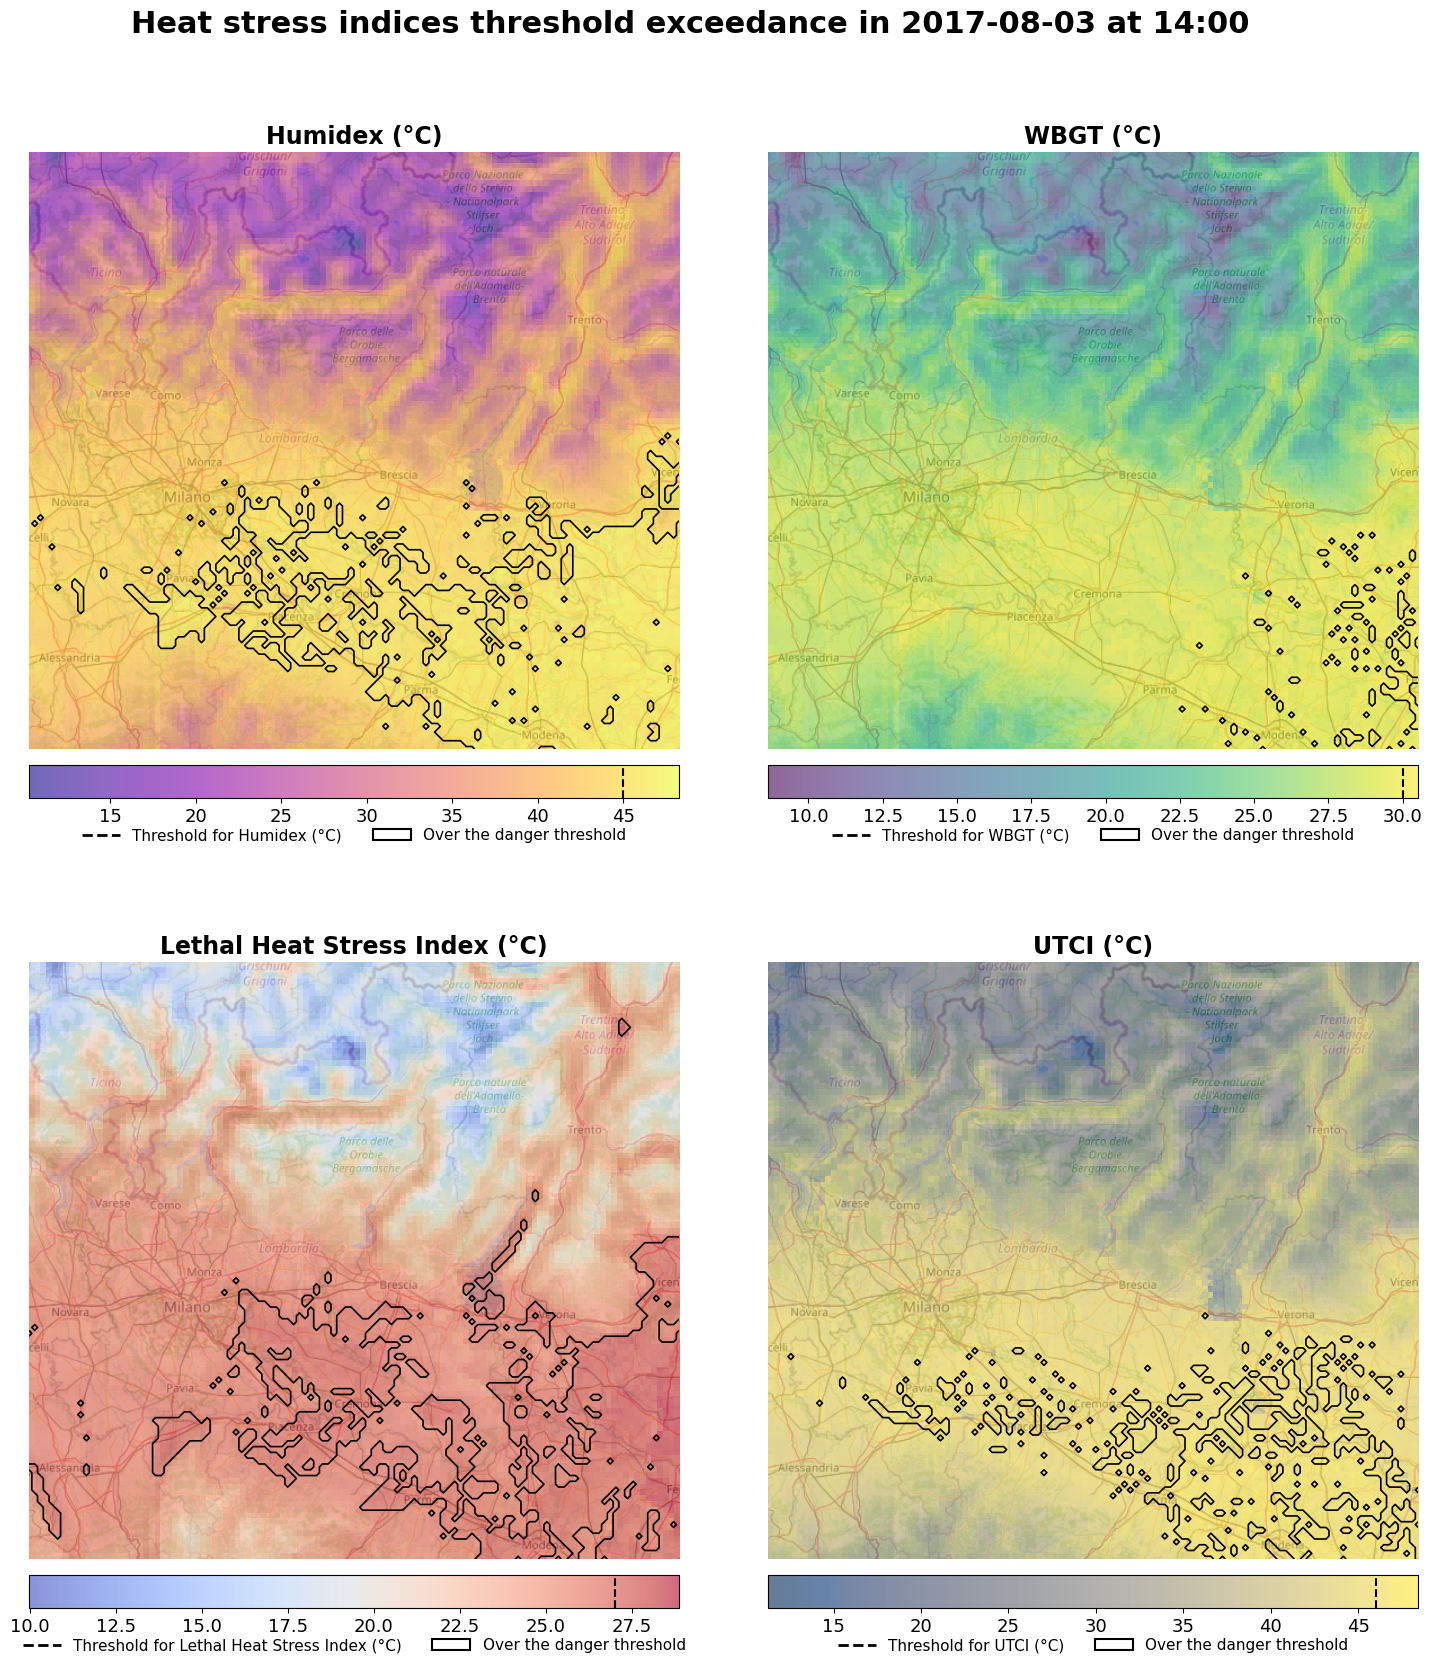

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# === PARAMETRI ===
selected_date = "2017-08-03"
selected_hour = 14

# === CARICAMENTO DATI ===
ds_temp = xr.open_dataset("C:/Users/andre/OneDrive/Desktop/Datasets_Geoinfprj/Enlarged_datasets/2m_air_temp/air_temperature_era5-81_23.nc")
ds_dew = xr.open_dataset("C:/Users/andre/OneDrive/Desktop/Datasets_Geoinfprj/Enlarged_datasets/dew_point_temp/dew_point_temp_81_23.nc")
ds_temp["time"] = pd.to_datetime(ds_temp["time"].values)
ds_dew["time"] = pd.to_datetime(ds_dew["time"].values)

timestamp = pd.Timestamp(f"{selected_date} {selected_hour:02d}:00")
T_k = ds_temp["T_2M"].sel(time=timestamp)
Td_k = ds_dew["TD_2M"].sel(time=timestamp)
Td_k = Td_k.where(Td_k > 243.15).interpolate_na(dim="rlat", method="linear").interpolate_na(dim="rlon", method="linear")

# === CALCOLO INDICI ===
T_c = T_k - 273.15
Td_c = Td_k - 273.15
RH = calculate_relative_humidity(T_c, Td_c)
humidex = calculate_humidex(T_k, Td_k)
wbt = calculate_wbt(T_c, RH)
wbgt = calculate_wbgt(T_c, wbt)
lhs = calculate_lethal_heat_stress_index(wbt, RH)
utci = calculate_utci(T_c, RH)

# === SOGHIE DI PERICOLOSITÀ ===
thresholds = {
    "Humidex (°C)": 45,
    "WBGT (°C)": 30,
    "Lethal Heat Stress Index (°C)": 27,
    "UTCI (°C)": 46
}

# === PARAMETRI DI STILE E PATH ===
title_fontsize = 22
map_title_fontsize = 17
colorbar_labelsize = 13

# === FUNZIONE DI PLOT MULTIPLO CON SOGLIE ===
def plot_4maps_with_thresholds(datasets, titles, cmaps, thresholds, alpha=0.6):
    fig, axs = plt.subplots(2, 2, figsize=(15, 17))
    plt.suptitle(f"Heat stress indices threshold exceedance in {selected_date} at {selected_hour}:00",
                 fontsize=title_fontsize, fontweight="bold", y=1.0)

    lat = ds_temp["lat"].values
    lon = ds_temp["lon"].values
    lon1d = lon[0, :] if lon.ndim == 2 else lon
    lat1d = lat[:, 0] if lat.ndim == 2 else lat

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    lon_mesh, lat_mesh = np.meshgrid(lon1d, lat1d)
    x_mesh, y_mesh = transformer.transform(lon_mesh, lat_mesh)

    axs = axs.flatten()

    for i, (data, title, cmap) in enumerate(zip(datasets, titles, cmaps)):
        ax = axs[i]
        ax.set_xlim(x_mesh.min(), x_mesh.max())
        ax.set_ylim(y_mesh.min(), y_mesh.max())
        ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik, attribution=False)

        im = ax.imshow(data.values, extent=[x_mesh.min(), x_mesh.max(), y_mesh.min(), y_mesh.max()],
                       origin='lower', cmap=cmap, alpha=alpha)
        ax.set_title(title, fontsize=map_title_fontsize, fontweight='bold')
        ax.axis("off")

        # === Colorbar ===
        cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.02)
        cbar.ax.tick_params(labelsize=colorbar_labelsize)

        # === Calcolo threshold
        threshold = thresholds.get(title, None)
        if threshold is not None:
            cbar.ax.axvline(x=threshold, color="black", linestyle="--", linewidth=1.5)

            mask = data.values > threshold
            ax.contour(x_mesh, y_mesh, mask.astype(int), levels=[0.5], colors='black',
                       linewidths=1.2, linestyles='solid')

            line_element = Line2D([0], [0], color="black", linestyle="--", linewidth=2,
                                  label=f"Threshold for {title}")
            rect_element = Rectangle((0, 0), 1, 1, facecolor="none", edgecolor="black", linewidth=1.5,
                                     label="Over the danger threshold")
            ax.legend(handles=[line_element, rect_element],
                      loc="lower center", bbox_to_anchor=(0.5, -0.18),
                      ncol=2, fontsize=11, frameon=False,
                      handlelength=2.5, handletextpad=0.8)

    plt.tight_layout()
    return fig

# === ESECUZIONE ===
fig = plot_4maps_with_thresholds(
    datasets=[humidex, wbgt, lhs, utci],
    titles=["Humidex (°C)", "WBGT (°C)", "Lethal Heat Stress Index (°C)", "UTCI (°C)"],
    cmaps=["plasma", "viridis", "coolwarm", "cividis"],
    thresholds=thresholds
)

# === ESPORTAZIONE FIGURA ===
output_path = rf"C:\Users\andre\OneDrive - Politecnico di Milano\Tesi_di_laurea\elab\04_Outputs\Heat_stress_indices_exceedance__{selected_date}_{selected_hour:02d}.png"  # <-- cambia con la tua directory preferita
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()